# 📚 CNN com CIFAR-10 – Notebook Detalhado
Este notebook implementa uma Rede Neural Convolucional simples para classificar imagens do dataset **CIFAR-10**.
Todas as etapas estão **comentadas linha por linha** para fins didáticos.
Inclui também Dropout e Data Augmentation como **opções desativadas** que podem ser usadas facilmente.

In [1]:
# ===============================================================
# IMPORTAÇÃO DAS BIBLIOTECAS
# ===============================================================

# ===============================================================
# TensorFlow é a biblioteca principal para construção e execução de redes neurais.
# Keras, que está embutido no TensorFlow, oferece uma API de alto nível para criar e treinar modelos.
# ===============================================================
import tensorflow as tf

# ===============================================================
# layers: módulo do Keras com tipos de camadas (Conv2D, MaxPooling2D, Dense, etc.)
# models: usado para criar modelos sequenciais ou funcionais
# ===============================================================
from tensorflow.keras import layers, models

# ===============================================================
# cifar10: dataset de imagens com 10 classes (avião, carro, pássaro, etc.)
# Está disponível diretamente em Keras
# ===============================================================
from tensorflow.keras.datasets import cifar10

# ===============================================================
# to_categorical: função utilitária para converter rótulos inteiros em vetores one-hot
# Necessária quando usamos 'categorical_crossentropy' como função de perda
# ===============================================================
from tensorflow.keras.utils import to_categorical

# ===============================================================
# NumPy: biblioteca para operações numéricas com arrays
# Utilizada para manipulação de imagens, rótulos e resultados
# ===============================================================
import numpy as np

# ===============================================================
# (Opcional) ImageDataGenerator: ferramenta para aplicar Data Augmentation
# Gera imagens transformadas (rotação, zoom, espelhamento) para enriquecer o treino
# Comentado por padrão, pode ser ativado quando necessário
# ===============================================================
# from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data Augmentation opcional


In [2]:
# ===============================================================
# ETAPA 1 – CARREGAMENTO E PRÉ-PROCESSAMENTO DOS DADOS
# ===============================================================

# ===============================================================
# Carrega o dataset CIFAR-10 diretamente do Keras
# O retorno é uma tupla com:
# - x_train, y_train: imagens e rótulos para treinamento
# - x_test, y_test: imagens e rótulos para teste
# Cada imagem tem dimensão 32x32 pixels com 3 canais (RGB)
# ===============================================================
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# ===============================================================
# Normalização dos valores dos pixels:
# - As imagens vêm com valores de 0 a 255 (uint8)
# - Convertendo para float32 e dividindo por 255, os valores vão para [0.0, 1.0]
# - Isso ajuda no treinamento, pois a rede aprende melhor com dados em escala padronizada
# ===============================================================
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# ===============================================================
# Codificação One-Hot dos rótulos:
# - y_train e y_test originalmente contêm apenas inteiros (0 a 9)
# - to_categorical transforma isso em vetores binários de tamanho 10
#   Exemplo: classe 3 → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
# - Isso é necessário para o uso com a função de perda categorical_crossentropy
# ===============================================================
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [3]:
# ===============================================================
# ETAPA 2 – DEFINIÇÃO DA ARQUITETURA DA CNN
# ===============================================================

# ===============================================================
# Criação do modelo sequencial
# ===============================================================
# O modelo Sequential permite empilhar camadas de forma linear
# (uma após a outra, da entrada até a saída)
model = models.Sequential()

# ===============================================================
# Primeira camada convolucional:
# - 32 filtros (ou kernels) de tamanho 3x3
# - Função de ativação ReLU (corrige não-linearidades)
# - input_shape define o formato das imagens de entrada: 32x32 pixels, 3 canais (RGB)
# ===============================================================
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))

# ===============================================================
# Camada de pooling (redução de dimensionalidade):
# - MaxPooling2D pega o valor máximo em janelas 2x2
# - Reduz a largura e altura pela metade
# ===============================================================
model.add(layers.MaxPooling2D((2, 2)))

# ===============================================================
# Segunda camada convolucional:
# - 64 filtros 3x3
# - Mais filtros = mais capacidade de capturar padrões complexos
# ===============================================================
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Segunda camada de pooling para nova redução de dimensão
model.add(layers.MaxPooling2D((2, 2)))

# ===============================================================
# Terceira camada convolucional:
# - Ainda com 64 filtros, sem pooling (manutenção da resolução atual)
# ===============================================================
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# ===============================================================
# Camada Flatten:
# - Transforma os mapas de ativação 3D em vetor 1D
# - Necessário para conectar com camadas densas (fully connected)
# ===============================================================
model.add(layers.Flatten())

# ===============================================================
# Camada densa intermediária:
# - 64 neurônios totalmente conectados
# - Ativação ReLU
# ===============================================================
model.add(layers.Dense(128, activation='relu'))

# ===============================================================
# Dropout (opcional):
# - Técnica para prevenir overfitting
# - Desativa aleatoriamente 50% dos neurônios durante o treino
# - Comentado por padrão (pode ativar se necessário)
# ===============================================================
# model.add(layers.Dropout(0.5))

# ===============================================================
# Camada de saída:
# - 10 neurônios (1 para cada classe do CIFAR-10)
# - Função softmax: retorna a probabilidade para cada classe
# ===============================================================
model.add(layers.Dense(10, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# ===============================================================
# ETAPA 3 – COMPILAÇÃO DO MODELO
# ===============================================================

# ===============================================================
# A compilação define como o modelo será treinado:
# - Otimizador: algoritmo que ajusta os pesos para minimizar o erro
# - Função de perda (loss): mede o quão longe a predição está do valor real
# - Métricas: métricas que serão monitoradas durante o treino e validação
# ===============================================================

model.compile(
    optimizer='adam',                    # Otimizador Adam: rápido e eficiente em muitos problemas
    loss='categorical_crossentropy',     # Perda para classificação multiclasse com one-hot encoding
    metrics=['accuracy']                 # Métrica de avaliação principal: acurácia (proporção de acertos)
)


In [5]:
# ===============================================================
# ETAPA 4 – TREINAMENTO DO MODELO (SEM DATA AUGMENTATION)
# ===============================================================
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=16,
                    validation_data=(x_test, y_test))

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.3787 - loss: 1.6878 - val_accuracy: 0.5641 - val_loss: 1.2096
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6029 - loss: 1.1162 - val_accuracy: 0.6368 - val_loss: 1.0321
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.6681 - loss: 0.9367 - val_accuracy: 0.6773 - val_loss: 0.9174
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.7122 - loss: 0.8167 - val_accuracy: 0.6847 - val_loss: 0.9187
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7393 - loss: 0.7356 - val_accuracy: 0.6897 - val_loss: 0.9103
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7678 - loss: 0.6644 - val_accuracy: 0.6969 - val_loss: 0.8940
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7838 - loss: 0.6002 - val_accuracy: 0.7050 - val_loss: 0.9067
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8110 - loss: 0

In [6]:
# ===============================================================
# ETAPA 4 (opcional) – COM DATA AUGMENTATION (descomente para usar)
# ===============================================================
# datagen = ImageDataGenerator(
#     rotation_range=15,           # Rotação aleatória
#     width_shift_range=0.1,       # Deslocamento horizontal
#     height_shift_range=0.1,      # Deslocamento vertical
#     horizontal_flip=True         # Inversão horizontal
# )
# datagen.fit(x_train)
# history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
#                     epochs=10,
#                     validation_data=(x_test, y_test))

In [7]:
# ===============================================================
# ETAPA 5 – AVALIAÇÃO DO MODELO NO CONJUNTO DE TESTE
# ===============================================================

# ===============================================================
# model.evaluate retorna dois valores:
# - test_loss: valor da função de perda (loss) no conjunto de teste
# - test_acc: acurácia final do modelo sobre os dados de teste
# ===============================================================
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# ===============================================================
# Exibe a acurácia final com duas casas decimais
# ===============================================================
print(f"Acurácia final no teste: {test_acc:.2f}")


313/313 - 2s - 5ms/step - accuracy: 0.7006 - loss: 0.9920
Acurácia final no teste: 0.70


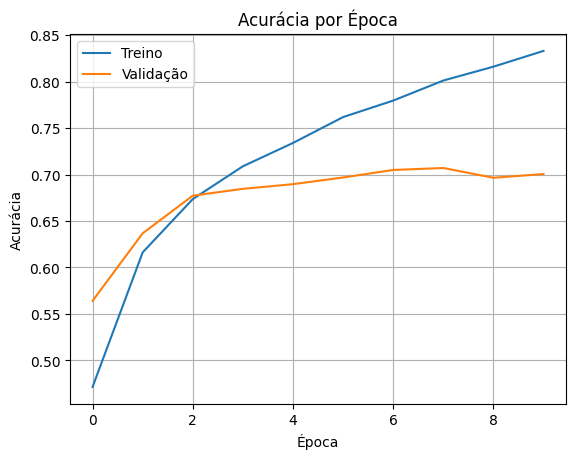

In [8]:
# ===============================================================
# VISUALIZAÇÃO – Gráfico de Acurácia por Época
# ===============================================================

import matplotlib.pyplot as plt  # Biblioteca para geração de gráficos

# ===============================================================
# Plotando as curvas de acurácia durante o treinamento
# ===============================================================

# history.history['accuracy']: acurácia nos dados de treino a cada época
# history.history['val_accuracy']: acurácia nos dados de validação a cada época
plt.plot(history.history['accuracy'], label='Treino')        # Linha da acurácia de treino
plt.plot(history.history['val_accuracy'], label='Validação') # Linha da acurácia de validação

# Título do gráfico
plt.title('Acurácia por Época')

# Rótulos dos eixos
plt.xlabel('Época')    # Eixo X representa o número de épocas
plt.ylabel('Acurácia') # Eixo Y representa a acurácia (0 a 1)

# Legenda para diferenciar as linhas
plt.legend()

# Ativa a grade para melhor visualização
plt.grid(True)

# Exibe o gráfico na tela
plt.show()


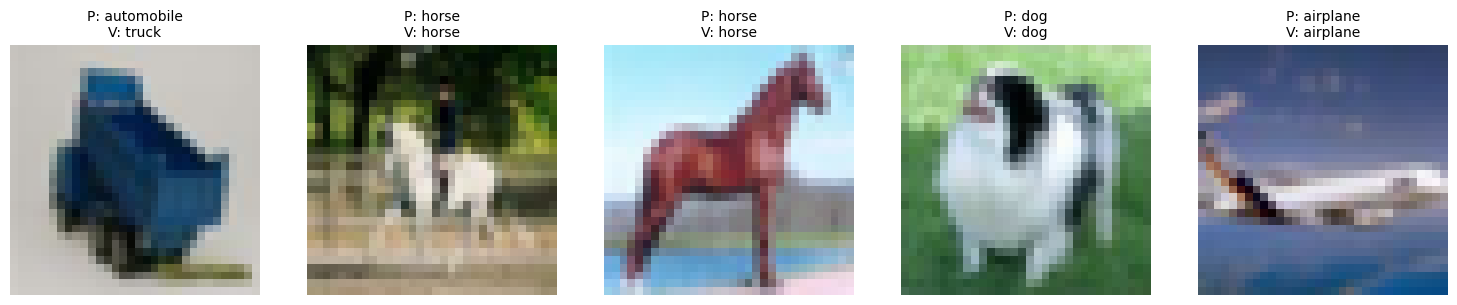

In [9]:
# ===============================================================
# VISUALIZAÇÃO DE PREDIÇÕES – Exibe imagens com rótulo verdadeiro e previsto
# ===============================================================

import matplotlib.pyplot as plt
import numpy as np

# ===============================================================
# Lista com os nomes das classes do CIFAR-10 (em ordem)
# Usada para converter índices numéricos em nomes legíveis
# ===============================================================
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# ===============================================================
# Define quantas imagens serão exibidas aleatoriamente
# ===============================================================
num_images = 5  # Número de imagens a mostrar
indices = np.random.choice(len(x_test), num_images, replace=False)  # Seleção aleatória sem repetição

# Define o tamanho da figura (em polegadas)
plt.figure(figsize=(15, 3))  # Largura = 15, altura = 3

# ===============================================================
# Loop para exibir cada imagem selecionada com sua predição
# ===============================================================
for i, idx in enumerate(indices):
    img = x_test[idx]  # Imagem de teste no índice sorteado

    # ===========================================================
    # y_test está em one-hot → convertemos para índice com argmax
    # ===========================================================
    true_label = np.argmax(y_test[idx])  # Índice da classe verdadeira
    true_class = class_names[int(true_label)]  # Nome da classe verdadeira

    # ===========================================================
    # Preparar a imagem para predição (modelo espera 4D: batch_size, altura, largura, canais)
    # ===========================================================
    img_input = np.expand_dims(img, axis=0)  # Adiciona dimensão de batch
    pred = model.predict(img_input, verbose=0)  # Faz predição
    pred_label = np.argmax(pred)  # Índice da classe prevista
    pred_class = class_names[pred_label]  # Nome da classe prevista

    # ===========================================================
    # Exibir a imagem em um subplot com título indicando rótulo previsto e verdadeiro
    # ===========================================================
    plt.subplot(1, num_images, i + 1)  # Linha única, várias colunas
    plt.imshow(img)  # Mostra a imagem RGB
    plt.title(f"P: {pred_class}\nV: {true_class}", fontsize=10)  # P: Predição, V: Verdade
    plt.axis('off')  # Remove os eixos

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


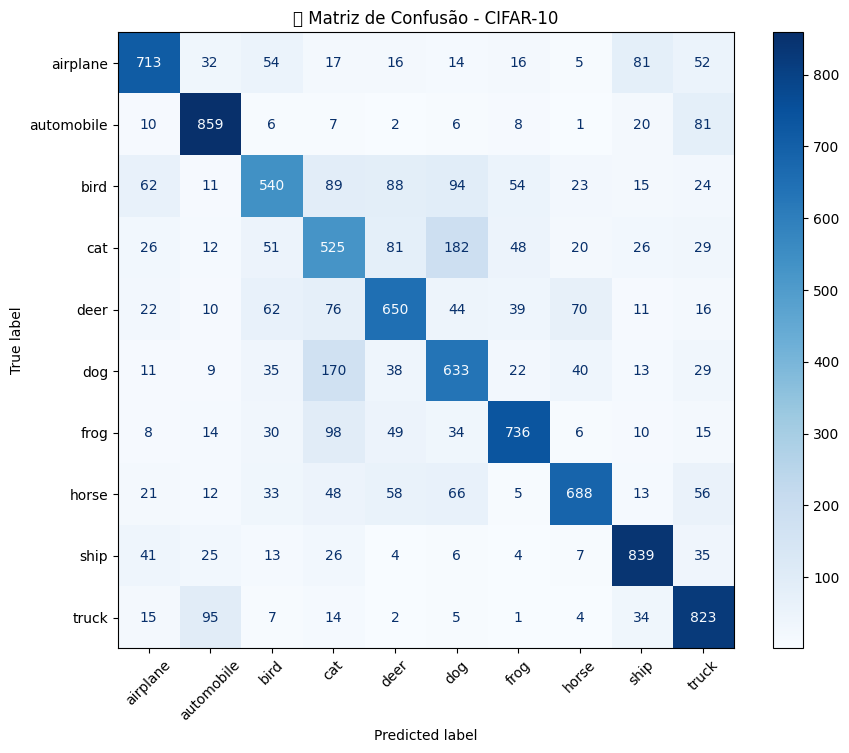

In [10]:
# ===============================================================
# MATRIZ DE CONFUSÃO – Avaliação detalhada por classe
# ===============================================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# ===============================================================
# O que é a matriz de confusão?
# ===============================================================
# Mostra onde o modelo acertou e onde errou por classe
# Cada linha representa a classe real
# Cada coluna representa a classe prevista
# Idealmente, os valores deveriam estar concentrados na diagonal principal

# ===============================================================
# Obter previsões do modelo para o conjunto de teste
# ===============================================================
y_pred_probs = model.predict(x_test, verbose=0)     # Saídas do modelo (probabilidades)
y_pred = np.argmax(y_pred_probs, axis=1)            # Índice da classe com maior probabilidade

# ===============================================================
# y_test está no formato one-hot (10 colunas), então precisamos converter:
# ===============================================================
y_true = np.argmax(y_test, axis=1)  # Converte para rótulos inteiros (0 a 9)

# ===============================================================
# Gera a matriz de confusão comparando rótulos verdadeiros com os previstos
# ===============================================================
cm = confusion_matrix(y_true, y_pred)

# ===============================================================
# Lista com os nomes das classes do CIFAR-10 (em ordem)
# ===============================================================
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# ===============================================================
# Cria visualização da matriz com cores e rótulos
# ===============================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Ajusta tamanho da figura e estilo da visualização
fig, ax = plt.subplots(figsize=(10, 8))             # Tamanho da figura
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)  # Coloração e rotação dos rótulos

# Título e exibição
plt.title("📊 Matriz de Confusão - CIFAR-10")
plt.show()


In [ ]:
# ===============================================================
# CLASSIFICAÇÃO DE UMA IMAGEM EXTERNA (UPLOAD)
# ===============================================================

from google.colab import files        # Para fazer upload de arquivos no Colab
from PIL import Image                 # Para abrir e redimensionar imagens
import numpy as np                    # Para manipulação numérica de arrays
import matplotlib.pyplot as plt       # Para exibição gráfica da imagem

# ===============================================================
# 1. Upload da imagem pelo usuário (vai abrir um seletor de arquivos)
# ===============================================================
uploaded = files.upload()

# ===============================================================
# 2. Pré-processamento da imagem selecionada
# ===============================================================
for fn in uploaded.keys():  # Itera sobre todos os arquivos enviados
    # Abrir a imagem com PIL e garantir que esteja no formato RGB
    img = Image.open(fn).convert('RGB')

    # Redimensionar a imagem para 32x32 pixels (formato padrão do CIFAR-10)
    img_resized = img.resize((32, 32))

    # Converter imagem para array NumPy e normalizar os valores para o intervalo [0, 1]
    img_array = np.array(img_resized).astype('float32') / 255.0

    # Adicionar dimensão extra para simular um batch (modelo espera entrada 4D: [batch, altura, largura, canais])
    img_input = np.expand_dims(img_array, axis=0)

    # ===========================================================
    # 3. Fazer a predição com o modelo treinado
    # ===========================================================
    pred = model.predict(img_input, verbose=0)  # Gera probabilidades para cada classe
    pred_label = np.argmax(pred)                # Pega o índice da classe com maior probabilidade

    # Lista de nomes das classes do CIFAR-10
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    # Obter o nome da classe prevista
    pred_class = class_names[pred_label]

    # ===========================================================
    # 4. Exibir a imagem enviada com o nome da classe prevista
    # ===========================================================
    plt.imshow(img_resized)                         # Mostra a imagem já redimensionada
    plt.title(f"🧠 Classe prevista: {pred_class}")   # Exibe o nome da classe prevista como título
    plt.axis('off')                                 # Remove os eixos da imagem
    plt.show()


🔹 "Perda para classificação multiclasse com one-hot encoding"
📌 Que "perda" é essa?
No treinamento de redes neurais, "perda" (loss) é uma medida que indica o quanto o modelo errou ao fazer uma previsão. Ela serve como feedback para ajustar os pesos da rede.

🔹 Classificação Multiclasse
Multiclasse significa que temos mais de duas categorias possíveis.

Exemplo: no CIFAR-10, temos 10 classes: 'airplane', 'automobile', 'bird', ....

🔹 One-Hot Encoding
Em vez de representar a classe como um número inteiro (3, por exemplo), usamos um vetor com 1 na posição da classe correta e 0 nas demais.

Exemplo:
Se a classe correta for 3, o vetor será:
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

🔹 categorical_crossentropy
Essa é a função de perda usada quando os rótulos estão em formato one-hot.

Ela compara a distribuição prevista (softmax) com a distribuição verdadeira (one-hot).

Quanto mais distante a predição estiver do 1 na posição correta, maior será a penalização.

✅ Resumo da frase:
A função categorical_crossentropy é usada como perda quando estamos lidando com classificação em múltiplas classes, e os rótulos dos dados estão no formato one-hot encoding.

One-hot encoding é uma técnica usada para representar categorias (classes) como vetores numéricos binários, de forma que cada categoria é transformada em um vetor com 1 em uma posição e 0 em todas as outras.

🔹 Exemplo simples
Suponha que você tenha 4 classes:
['gato', 'cachorro', 'pássaro', 'peixe']

Elas seriam representadas assim com one-hot encoding:

Classe	One-Hot Encoding
gato	[1, 0, 0, 0]
cachorro	[0, 1, 0, 0]
pássaro	[0, 0, 1, 0]
peixe	[0, 0, 0, 1]

Cada vetor tem o mesmo número de posições que o número de classes. A posição do 1 indica qual é a classe.

🔹 Por que usar isso?
Modelos de machine learning não entendem texto ou categorias diretamente.

One-hot encoding transforma classes nominais (como "gato") em números binários que a rede pode usar.

Em redes neurais com softmax na saída, usamos one-hot encoding para ensinar ao modelo a resposta correta.

🔹 Quando não usar?
Se seus rótulos forem inteiros simples (ex: 0, 1, 2, 3) e você usar a função de perda sparse_categorical_crossentropy, não precisa aplicar one-hot — o modelo cuidará disso internamente.


